In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

# Fetch Adult dataset reliably from OpenML
adult = fetch_openml('adult', version=2, as_frame=True)
data = adult.frame.copy()

# Unify target column name
data = data.rename(columns={'class': 'income'})

# Strip whitespace from string columns for robustness
for c in data.select_dtypes(include='object'):
    data[c] = data[c].str.strip()

# Split
X = data.drop(columns=['income'])
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
34342,71,Private,77253,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,17,United-States
18559,17,Private,329783,10th,6,Never-married,Sales,Other-relative,White,Female,0,0,10,United-States
12477,27,Private,91257,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,El-Salvador
560,43,Private,125577,HS-grad,9,Separated,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States
3427,31,Private,137978,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


In [2]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Automatic selectors
numeric_features = selector(dtype_include=['int64', 'float64'])
categorical_features = selector(dtype_include=['object', 'category'])

# Robust OneHotEncoder (handles different sklearn versions)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79b583aeac60>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x79b58423f7a0>)])),
                ('model', LogisticRegression(max_iter=1000))])

In [4]:
from sklearn.metrics import accuracy_score

preds = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))


Accuracy: 0.8462483365748797


In [5]:
import numpy as np

# Ensure original 'sex' column exists in X_test
sex_col = X_test['sex'].str.strip()
is_male = sex_col.eq('Male')
is_female = sex_col.eq('Female')

preds_series = pd.Series(preds, index=X_test.index)

# Positive class in Adult dataset is '>50K'
male_pos_rate = (preds_series[is_male] == '>50K').mean()
female_pos_rate = (preds_series[is_female] == '>50K').mean()
fairness_gap = abs(male_pos_rate - female_pos_rate)

print("Predicted Positive Rate (Male):", round(male_pos_rate, 3))
print("Predicted Positive Rate (Female):", round(female_pos_rate, 3))
print("Fairness Gap:", round(fairness_gap, 3))


Predicted Positive Rate (Male): 0.248
Predicted Positive Rate (Female): 0.069
Fairness Gap: 0.179


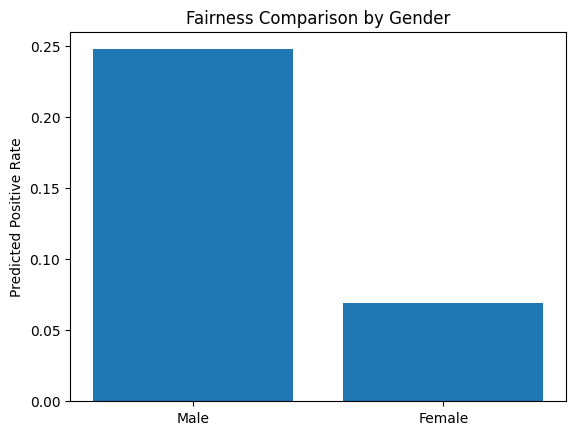

In [6]:
import matplotlib.pyplot as plt

plt.bar(['Male', 'Female'], [male_pos_rate, female_pos_rate])
plt.title('Fairness Comparison by Gender')
plt.ylabel('Predicted Positive Rate')
plt.show()
